# Functional Enrichment Analysis

Author: Ashley Schwartz

Date: October 2023

## Purpose and Background

This tutorial goes over how to retrieve the genes in a particular pathway from the Kyoto Encyclopedia of Genes and Genomes (KEGG), retrieve the genes in a particular function from Gene Ontology (GO), and perform gene enrichment analysis on these gene sets using a variety of different methods.

**Databases Supported**

| Database   | Abbreviation | Description   | Link |
|------|--------------|------------------|-------------------|
| Kyoto Encyclopedia of Genes and Genomes Pathway Database | KEGG Pathway | Molecular pathways and interactions              | [link](https://www.genome.jp/kegg/pathway.html)        |
| Kyoto Encyclopedia of Genes and Genomes Disease Database | KEGG Disease | Genes and pathways associated with diseases      | [link](https://www.genome.jp/kegg/disease/)           |
| Gene Ontology Biological Process Database                | GO BP        | Molecular events in biological processes         | [link](http://geneontology.org/docs/ontology-documentation/#biological-process-ontology-bp) |
| Gene Ontology Cellular Component Database                | GO CC        | Cellular structures and locations                | [link](http://geneontology.org/docs/ontology-documentation/#cellular-component-ontology-cc) |
| Gene Ontology Molecular Function Database                | GO MF        | Specific activities or functions of gene products | [link](http://geneontology.org/docs/ontology-documentation/#molecular-function-ontology-mf) |

**Database Naming Conventions**

Each database follows naming conventions for their pathways and functions. For a quick overview of how each database names a particular pathway or function, we provide some examples here:

| Database      | ID Format      | Example ID   | Pathway/Function Name | Notes |
|---------------|----------------|--------------|-----------------------|-------|
| KEGG Pathway  | Numeric with Prefix | dre00120 (Zebrafish), hsa00120 (Human)| Primary bile acid biosynthesis | KEGG pathway IDs are species-specific.|
| KEGG Disease  | Alphanumeric  | H00001 (Human) | B-cell acute lymphoblastic leukemia | KEGG disease IDs are identified for human and are not defined for zebrafish.|
| GO BP         | Alphanumeric  | GO:0007165 | Signal transduction | GO BP IDs are unique to each species.|
| GO CC         | Alphanumeric  | GO:0005634 | Nucleus | GO CC IDs are unique to each species.|
| GO MF         | Alphanumeric  | GO:0003824 | Catalytic activity | GO MF IDs are unique to each species.|

**Enrichment Methods Supported**

| Enrichment Method     | Description                                                      |
|-----------------------|------------------------------------------------------------------|
| Fisher's Exact Test   | A statistical method for assessing the significance of gene enrichment within predefined functional categories or pathways using categorical gene set data. |
| Logistic Regression    | A modeling technique for predicting gene enrichment in specific functional categories, offering flexibility to handle diverse data types within gene sets. |

**Organisms Supported**

`danRerLib` is built for zebrafish and supports three organism types:

The table you've provided is clear and informative, but there appears to be a minor typographical error in the descriptions for "zebrafish" and "mapped zebrafish." Here's a corrected version:

**Organisms Supported**

`danRerLib` is built for zebrafish and supports three organism types:

| Organism       | Abbreviation | Description                               |
| ---------------|--------------| ------------------------------------------|
| Zebrafish      | 'dre'        | The zebrafish taxonomy                     |
| Human          | 'hsa'        | The human taxonomy                         |
| Mapped Zebrafish | 'dreM'      | An organism defined through orthology     |


## Requirements

In this tutorial we will be utilizing:
- the required python package
    - see install notes if not currently installed.


In [1]:
# IMPORT PYTHON PACKAGE
# ---------------------
from danrerlib import KEGG, utils, GO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Download Gene Sets

If you are interested in identifying the genes within a gene set, you can download genes for a given KEGG pathway id, KEGG disease id, or GO id (BP, CC, or MF). A key benefit and advantage to `danRerLib` is we can also generate the gene list for a pathway that might not exist for zebrafish, but does exist for human. We can then map the genes to zebrafish genes if desired.

### KEGG Pathway

_Purpose: Given a KEGG pathway id, retrieve a list of all genes in said pathway._

As a reminder, `danRerLib` supports three organism types (see background for more information): hsa, dre, and dreM. Of course, you are likely most interested in the zebrafish genes, but human genes are also provided for comparisons. Lets look at the KEGG pathway `00400` which is defined as phenylalanine, tyrosine and tryptophan biosynthesis. This pathway exists for human `hsa00400` and zebrafish `dre00400`. Here are a few examples of gathering the genes in this pathway for different organisms:

In [2]:
kegg_id = '00400'
human_genes = KEGG.get_genes_in_pathway(kegg_id, 'hsa')
human_genes

,Human NCBI Gene ID
0,137362
1,259307
2,2805
3,2806
4,5053
5,6898


In [3]:
dre_genes = KEGG.get_genes_in_pathway(kegg_id, 'dre')
dre_genes

,NCBI Gene ID
0,335974
1,337166
2,378962
3,406330
4,406688
5,561410
6,791730


In [4]:
mapped_genes = KEGG.get_genes_in_pathway(kegg_id, 'dreM')
mapped_genes

,NCBI Gene ID
0,561410
1,335974
2,337166
3,378962
4,406330
5,406688
6,791730


It is also possible to include the organism identifier in the KEGG id sent to the function and omit the organism identifier. As an example of this, see below where we only provide the full KEGG id desired.

In [5]:
KEGG.get_genes_in_pathway('hsa00400')

,Human NCBI Gene ID
0,137362
1,259307
2,2805
3,2806
4,5053
5,6898


### KEGG Disease

_Purpose: Given a KEGG disease id, retrieve a list of all genes in said disease._

We can also get the list of genes for a particular disease listed in the KEGG database. This function takes the disease id and the organism. Not that the zebrafish organism in this case comes from mapped values as the disease gene lists are not annotated for zebrafish within the KEGG database. 

In [6]:
# human organism
KEGG.get_genes_in_disease('H00001', 'hsa')

,Human NCBI Gene ID
0,25
1,4297
2,4299
3,6929
4,5087
5,861
6,4609
7,64109
8,5079


In [7]:
# zebrafish organism
KEGG.get_genes_in_disease('H00001', 'dre')

,NCBI Gene ID
0,100000720
1,557048
2,100537394
3,664768
4,30310
5,58138
6,570960
7,58126
8,393141
9,30686


It is expected, as described in the mapping tutorial, that the number of genes in the human gene set may not always be equal to the number of genes in the zebrafish set. This is because there is not always a 1:1 mapping in orthology between human ans zebrafish taxonomy. 

### Gene Ontology

_Purpose: Given a Go concept id, retrieve a list of all genes in said GO concept._

`danRerLib` supports Gene Ontology Biological Processes (BP), Cellular Components (CC), and Molecular Functions (MF). There is one primary function for the GO module that will retrieve the genes in any given concept, regardless if it comes from BP, CC, or MF. This can be done for either organism (hsa, dre, or dreM). Retrieval of the GO id `GO:0033554`, cellular response to stress, is shown below for the zebrafish. 

In [8]:
# zebrafish organism
GO.get_genes_in_GO_concept('GO:0033554', 'dre')

,ZFIN ID
0,ZDB-GENE-030131-8638
1,ZDB-GENE-091204-246
2,ZDB-GENE-040718-255
3,ZDB-GENE-050320-35
4,A0A2R8S050
5,ZDB-GENE-030131-6701
6,ZDB-GENE-040825-4
7,ZDB-GENE-030131-1096
8,ZDB-GENE-030131-9531
9,ZDB-GENE-030826-18


## Conduct Functional Enrichment Analysis

Functional enrichment analysis is a powerful method for uncovering biological insights from a set of genes. Whether you have a specific gene set of interest or an entire dataset, you are able to perform functional enrichment analysis on pathways from KEGG and Gene Ontology. In this section, we'll explore different scenarios, from analyzing a small gene set to conducting enrichment analysis on a larger scale using the danRerLib package. 

### Enrichment Module Overview

**Import Enrichment Module**

In [9]:
from danrerlib.enrichment import enrich

# can also import as:
# from danrerlib import enrichment

**Recommended Data Format:** The functional enrichment package is designed to take in your differential expression results and output the pathways significantly altered. Therefore, your data should include every gene detected from your study, the associated p-value that defines significance of differential expression, and the log2fc (or another metric that defines up/down regulation of the gene). This minimizes the work from the user with regard to data filtering for directional tests and background gene sets. The **required** data format is:

| Gene ID | p-value | log2FC | 
| --- | --- | --- | 
| any supported gene id type: NCBI Gene ID, ZFIN ID, Ensembl ID, Symbol | 0 < p-value < 1 | positive or negative |

*The data is required to have the gene id in the first column, the pvalue in the second, and the log2FC in the third. The column names can be defined by the user.*

The data I will be using in this tutorial is a publicly available differential expression dataset from the Gene Expression Omnibus (GSE:...). The study investigated the effects of the chemical TPP on the developing zebrafish and obtained whole-embryo RNA-sequencing.

**Required Parameters**

| Parameter Name | Parameter Type | Parameter Description | 
| -- | -- | -- |
| `gene_universe` | `pd.DataFrame` | A DataFrame containing gene information, including gene IDs, p-values, and log2FC. |
| `gene_id_type` | `str` | The type of gene ID in the gene universe. The recommended gene id type is NCBI Gene ID (NCBI_ID). Must be one of: NCBI Gene ID, ZFIN ID, Ensembl ID, Symbol, or for human: Human NCBI Gene ID. | 
| `database` | `str` | The functional annotation database. Options include:'KEGG Pathway', 'KEGG Disease', 'GO BP', 'GO CC', 'GO MF', 'GO' (all GO databases), 'all' ( all databases). |

**Advanced, Optional Parameters**

| Parameter Name | Parameter Type | Parameter Description | 
| -- | -- | -- |
| `org` | `str` | The organism code ('dre' for zebrafish, 'dreM' for mapped zebrafish, 'hsa' for human). Choose `dreM` if you would like to preform enrichment via orthology. Default is `dre` | 
| `method` | `str` | The enrichment analysis method ('logistic' or 'fishers'). Default is 'logistic'. | 
| `direction` | `str` |  The direction of statistical test for enrichment ('up', 'down', or 'both'). If you choose `up` for example, you will be able to test if the gene set is significantly up-regulated. Default is 'both'. | 
| `sig_gene_cutoff_pvalue ` | `float` | The significance cutoff for gene inclusion based on p-values. Default is 0.05. | 
| `log2FC_cutoff_value` |  `float` | The log2 fold change cutoff value for gene inclusion. Default is 0. | 
| `min_num_genes_in_concept` | `int` | The minimum number of genes in a concept for it to be considered. Default is 10. |
| `concept_ids`  | `list` | A list of concept IDs (e.g., pathway IDs or disease IDs) to analyze. Include this if you are interested in testing a specific amount of concept IDs. Default is None.
| `background_gene_set` | `pd.DataFrame` | A DataFrame representing a background gene set. Include if your gene universe does not contain all genes detected. Default is None. |
| `sig_conceptID_cutoff_pvalue` | `float` | The significance cutoff for concept IDs based on p-values that will be returned to you. Default is 0.05. | 
| `include_all`  | `bool` | Include all results without filtering based on significance. Default is False. |
| `order_by_p_value` |  `bool` |  Whether to order the results by p-value. Default is True. | 

### Functional Enrichment with Fisher's Exact Test

_Purpose: Conduct functional enrichment analysis using Fisher's Exact Test to identify overrepresented pathways associated with a set of genes._

This method is ideal for scenarios where you have a gene set of interest and want to explore the significant enrichment of pathways from databases like KEGG and Gene Ontology. The Fisher's Exact Test helps reveal statistically significant relationships between the gene set and specific pathways.

#### Overview of Fisher's Exact Test for Overrepresentation

**Contingency Table:**

Consider a scenario where we are assessing the enrichment of a specific KEGG Pathway (let's call it "Pathway A") in a set of differentially expressed genes. The contingency table could look like this:

$$
\begin{array}{|c|c|c|}
\hline
 & \text{In Pathway A} & \text{Not In Pathway A} \\
\hline
\text{Significantly Expressed} & a & b \\
\hline
\text{Not Significantly Expressed} & c & d \\
\hline
\end{array}
$$

In this table:

- $a$ is the number of genes both in the pathway and significantly expressed.
- $b$ is the number of genes not in the pathway but significantly expressed.
- $c$ is the number of genes in the pathway but not significantly expressed.
- $d$ is the number of genes neither in the pathway nor significantly expressed.

**Statistical Formulas:**

1. **Odds Ratio:**
$$
\text{Odds Ratio} = \frac{ad}{bc}
$$

2. **Fisher's Exact Test:**
$$
P(X \leq a) = \frac{\binom{a+b}{a} \binom{c+d}{c}}{\binom{N}{a+c}}
$$
where $N = a+b+c+d$ is the total number of genes.

3. **P-value Calculation:**
$$
P(\text{Observed or More Extreme}) = \sum_{I=0}^{a} \frac{\binom{a+b}{i} \binom{c+d}{a-i}}{\binom{N}{a+c}}
$$

A low p-value suggests that the observed distribution is unlikely to occur by random chance, indicating potential enrichment or depletion.

**Step 1:** Loading Data. Data should be loaded into a Pandas Dataframe with the structure as describes above. This is defined as your `gene_universe_tpp` as is contains all genes detected in your study.

In [10]:
gene_universe_tpp = pd.read_csv('data/test_data/TPP_DE.txt', sep = '\t')

To get a sneak peak about what the data looks like, we can look at the first 5 elements:

In [11]:
gene_universe_tpp.head(5)

,NCBI Gene ID,PValue,logFC
0,100000006,0.792615,0.115009
1,100000009,0.607285,-0.144714
2,100000026,0.021338,0.603871
3,100000030,0.007880,-2.083141
4,100000044,0.015286,0.803879


**Step 2:** Define necessary parameters and choices. To run the enrichment function, there are some key parameters you have the option of using (see above). 

In [12]:
# the gene id type you have in your gene universe. 
# In this case, we have NCBI Gene IDs. 
ncbi_id = 'NCBI Gene ID'

# the database you wish to test enrichment for 
database_choice = 'KEGG Pathway'

# the method you wish to use to test for enrichment. 
# In this case, we are using Fisher's Exact Test
enrich_method = 'fishers'

**Step 3** Run enrichment function.

In [13]:
result = enrich(gene_universe = gene_universe_tpp, 
                gene_id_type = ncbi_id,
                database = database_choice, 
                method = enrich_method     
                )

**Step 4** Visualize results. In this case, we assessed whether or not a KEGG Pathway was enriched or depleted. This means was there significant up and/or down regulation of a pathway. 

In [14]:
# count the number of significantly altered pathways
num_altered = len(result)
num_enriched = len(result[result['Direction'] == 'enriched'])
num_depleted = len(result[result['Direction'] == 'depleted'])

print(f'The total number of altered pathways is {num_altered}, the number enriched is {num_enriched}, and the number depleted is {num_depleted}.')

The total number of altered pathways is 28, the number enriched is 25, and the number depleted is 3.


In [15]:
# visualize the top 5 most significantly altered KEGG pathways
result.head(5)

,Concept Type,Concept ID,Concept Name,# Genes in Concept in Universe,# Sig Genes Belong to Concept,Proportion of Sig Genes in Set,Odds Ratio,P-value,Direction
0,KEGG Pathway,dre00030,Pentose phosphate pathway,29,15,0.517241,4.872631,0.000041,enriched
1,KEGG Pathway,dre04512,ECM-receptor interaction,101,35,0.346535,2.416984,0.000071,enriched
2,KEGG Pathway,dre04141,Protein processing in endoplasmic reticulum,190,54,0.284211,1.811383,0.000419,enriched
3,KEGG Pathway,dre04010,MAPK signaling pathway,377,95,0.251989,1.540432,0.000545,enriched
4,KEGG Pathway,dre04510,Focal adhesion,264,69,0.261364,1.615107,0.001212,enriched


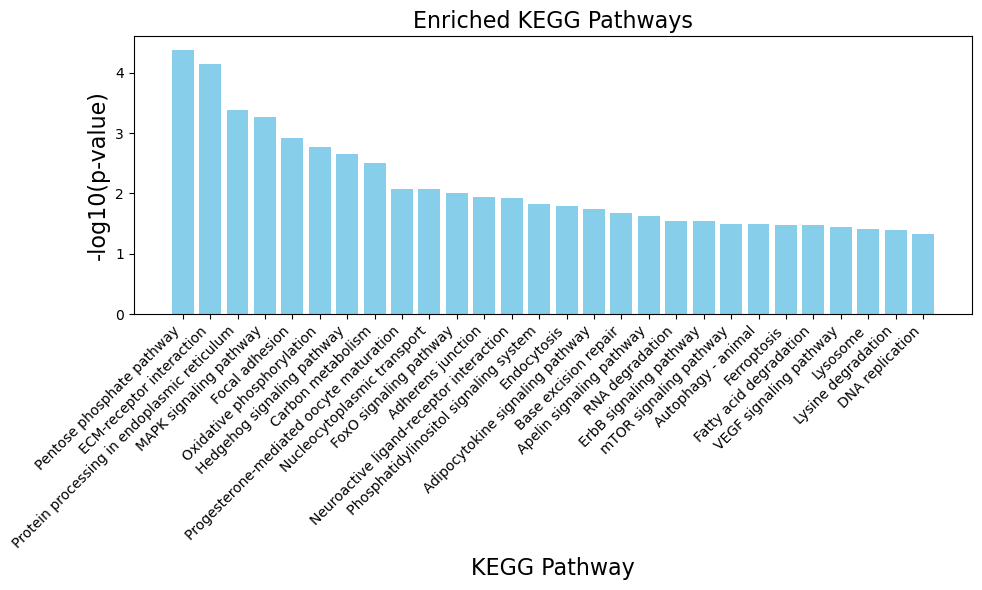

In [16]:
# create a bar chart to visualize the enriched results
enriched_results = result[result['Direction'] == 'enriched']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result['Concept Name'], -np.log10(result['P-value']), color='skyblue')
plt.xlabel('KEGG Pathway', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.title('Enriched KEGG Pathways', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Step 5** Interpretation. Interpret the results based on the direction of enrichment. Consider the biological context of the pathways and their relevance to your study.

For example, the Pentose phosphate pathway is significantly enriched in the set of genes that are differentially expressed in zebrafish exposed to TPP. The odds ratio of 4.87 and a very low p-value (0.000041) suggest a strong association between the pathway and the significant genes. The term "enriched" indicates that there is an overrepresentation of significant genes in this pathway compared to what would be expected by chance.

#### Testing for Up-Regulated Pathways

**Contingency Table for Upregulated Genes:**

Assume we are interested in assessing whether a KEGG Pathway (let's call it "Pathway A") is enriched with _upregulated genes_. The contingency table for this scenario would be:

$$
\begin{array}{|c|c|c|}
\hline
 & \text{In Pathway A} & \text{Not In Pathway A} \\
\hline
\text{Upregulated} & a & b \\
\hline
\text{Not Upregulated} & c & d \\
\hline
\end{array}
$$

Here:
- $a$ is the number of genes both in the pathway and upregulated.
- $b$ is the number of genes not in the pathway but upregulated.
- $c$ is the number of genes in the pathway but not upregulated.
- $d$ is the number of genes neither in the pathway nor upregulated.


**Step 1:** Load the data. We will use the same dataset as before.

In [17]:
gene_universe_tpp = pd.read_csv('data/test_data/TPP_DE.txt', sep = '\t')

**Step 2:** Define necessary parameters and choices. The key difference here is the test direction.

In [18]:
# same as before
ncbi_id = 'NCBI Gene ID'
database_choice = 'KEGG Pathway'
enrich_method = 'fishers'

# define the directional test
tes_direction = 'up'

**Step 3** Run enrichment function.

In [19]:
result = enrich(gene_universe = gene_universe_tpp, 
                gene_id_type = ncbi_id,
                database = database_choice, 
                method = enrich_method,
                direction = 'up'     
                )

**Step 4** Visualize results. In this case, we assessed whether or not a KEGG Pathway was upregulated. 

In [20]:
# count the number of significantly altered pathways
num_altered = len(result)
num_upregulated = len(result[result['Direction'] == 'up regulated'])

print(f'The total number of altered pathways is {num_altered} and the number upregulated is {num_upregulated}.')

The total number of altered pathways is 13 and the number upregulated is 13.


As you can see, since we are doing a directional test, the only ones that are significant are those that are up-regulated.

In [21]:
result.head(5)

,Concept Type,Concept ID,Concept Name,# Genes in Concept in Universe,# Sig Genes Belong to Concept,Proportion of Sig Genes in Set,Odds Ratio,P-value,Direction
0,KEGG Pathway,dre04010,MAPK signaling pathway,377,64,0.169761,2.014559,0.000002,up regulated
1,KEGG Pathway,dre04144,Endocytosis,325,47,0.144615,1.654480,0.001757,up regulated
2,KEGG Pathway,dre04140,Autophagy - animal,180,28,0.155556,1.797218,0.005091,up regulated
3,KEGG Pathway,dre04012,ErbB signaling pathway,104,18,0.173077,2.038760,0.007565,up regulated
4,KEGG Pathway,dre04070,Phosphatidylinositol signaling system,117,19,0.162393,1.888295,0.012139,up regulated


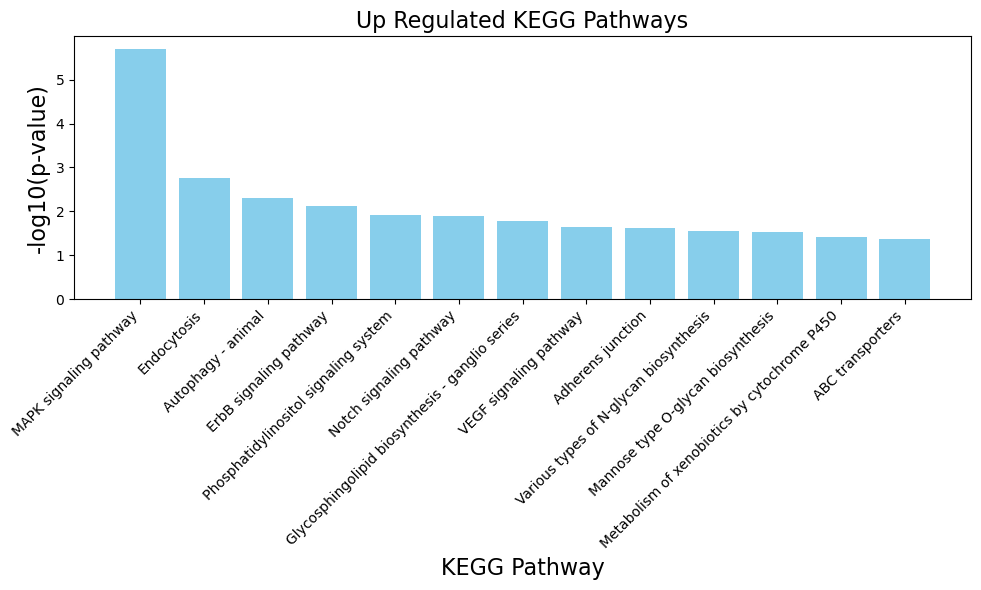

In [22]:
# create a bar chart to visualize the enriched results
upregulated_results = result[result['Direction'] == 'up regulated']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(upregulated_results['Concept Name'], -np.log10(upregulated_results['P-value']), color='skyblue')
plt.xlabel('KEGG Pathway', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.title('Up Regulated KEGG Pathways', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Testing for Down-Regulated Pathways

**Contingency Table for Upregulated Genes:**

Assume we are interested in assessing whether a KEGG Pathway (let's call it "Pathway A") is enriched with _down regulated genes_. The contingency table for this scenario would be:

$$
\begin{array}{|c|c|c|}
\hline
 & \text{In Pathway A} & \text{Not In Pathway A} \\
\hline
\text{Downregulated} & a & b \\
\hline
\text{Not Downregulated} & c & d \\
\hline
\end{array}
$$

Here:
- $a$ is the number of genes both in the pathway and downregulated.
- $b$ is the number of genes not in the pathway but downregulated.
- $c$ is the number of genes in the pathway but not downregulated.
- $d$ is the number of genes neither in the pathway nor downregulated.

**Steps 1-6:** You can repeat the steps above to test for down-regulated genes.

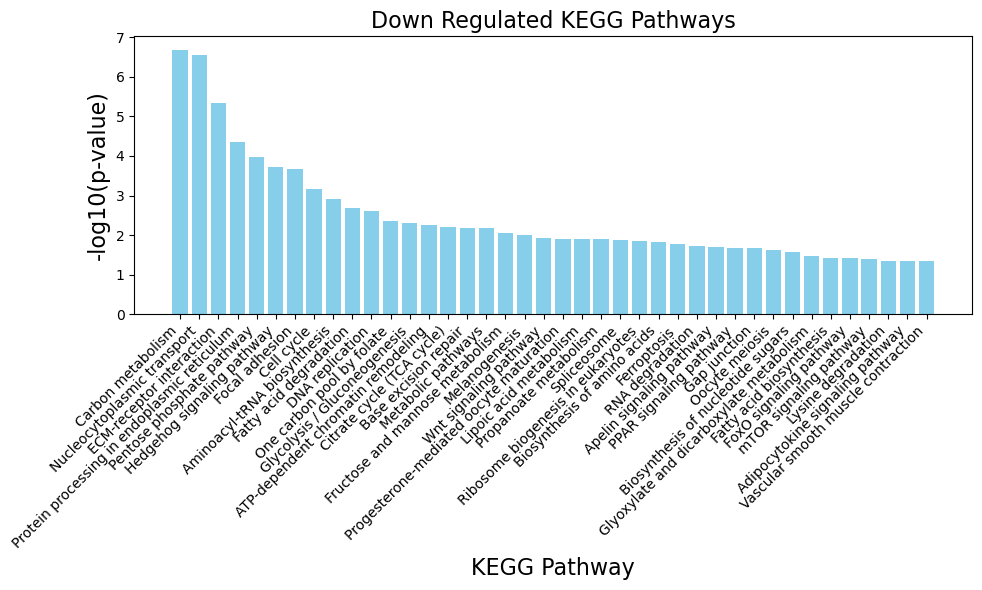

In [35]:
result = enrich(gene_universe = gene_universe_tpp, 
                gene_id_type = ncbi_id,
                database = database_choice, 
                method = 'fishers',
                direction = 'down')                

# create a bar chart to visualize the enriched results
downregulated_results = result[result['Direction'] == 'down regulated']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(downregulated_results['Concept Name'], -np.log10(downregulated_results['P-value']), color='skyblue')
plt.xlabel('KEGG Pathway', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.title('Down Regulated KEGG Pathways', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

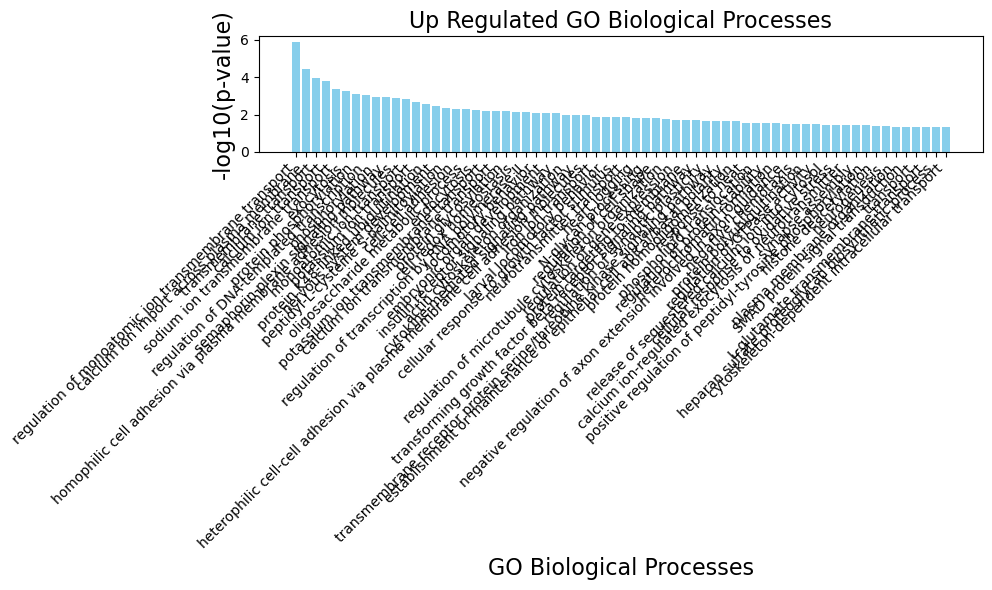

In [36]:
result = enrich(gene_universe = gene_universe_tpp, 
                gene_id_type = 'NCBI Gene ID',
                database = 'GO BP', 
                method = 'fishers',
                direction = 'up')                

In [ ]:
# create a bar chart to visualize the enriched results
upregulated_results = result[result['Direction'] == 'up regulated']

# just do top 10 

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(upregulated_results['Concept Name'], -np.log10(upregulated_results['P-value']), color='skyblue')
plt.xlabel('GO Biological Processes', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.title('Up Regulated GO Biological Processes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()